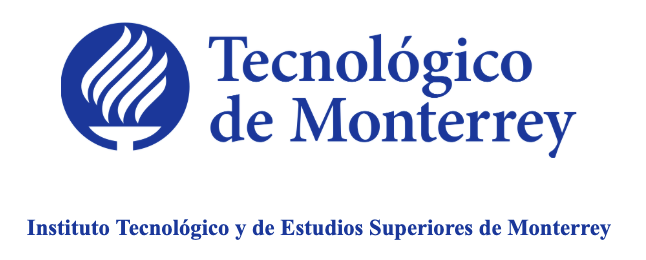



*   Adriana Paola Herdoiza Morales			A01796966
*   Guillermo Herrera.                  A01400835
*   Jesús Alberto Jiménez Ramos         A01796903
*   Aldo Rene Hernandez Kerckoff.       A01795630




# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [3]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("Torch CUDA version:", torch.version.cuda)

if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

CUDA available: False
Torch CUDA version: None


In [4]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as datasets
import torchvision.transforms as T
from torchvision import models

In [5]:
import matplotlib.pyplot as plt

### Descargar sets de datos

In [6]:
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
#DATA_PATH = '/content/drive/MyDrive/Colab Notebooks/MNA/Advanced Machine Learning Methods (Gpo 10)/Activity 2c/'
DATA_PATH = r'C:\dev\Advance ML Operations'
NUM_TRAIN = 45000
MINIBATCH_SIZE = 64
transform_imagenet = T.Compose([
                T.Resize(224),
                T.ToTensor(),
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
            ])

transform_cifar = T.Compose([
                T.ToTensor(),
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261])
            ])

# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

100%|██████████| 170M/170M [00:02<00:00, 76.0MB/s]


In [7]:
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Usar GPU

In [8]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

print(device)

cpu


### Mostrar imágenes

La imagen muestreada representa un: Truck


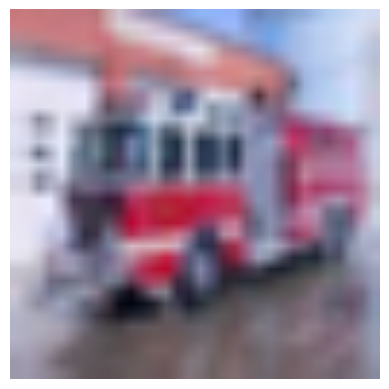

In [9]:
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

def plot_figure(image):
    plt.imshow(image.permute(1,2,0))
    plt.axis('off')
    plt.show()

rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )
plot_figure(image)

### Calcular Accuracy

In [10]:
def accuracy(model, loader):
    num_correct = 0
    num_total = 0
    model.eval()
    model = model.to(device=device)
    with torch.no_grad():
        for (xi, yi) in loader:
            xi = xi.to(device=device, dtype = torch.float32)
            yi = yi.to(device=device, dtype = torch.long)
            scores = model(xi) # mb_size, 10
            _, pred = scores.max(dim=1) #pred shape (mb_size )
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1)
            num_total += pred.size(0)
        return float(num_correct)/num_total

### Cargar modelo pre-cargado

In [11]:
#model_resnet18 = models.resnet18(pretrained=True)

# Updated to use the new torchvision API: 'pretrained=True' is deprecated.
# We now explicitly specify pretrained weights using the 'weights' argument
# for compatibility with torchvision >= 0.13 and future versions.

weights = models.ResNet18_Weights.DEFAULT
model_resnet18 = models.resnet18(weights=weights)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 157MB/s]


#### Exploremos el modelo

In [12]:
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [13]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [14]:
model_aux = nn.Sequential(*list(model_resnet18.children()))
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [15]:
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [16]:
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [17]:
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [18]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento

In [19]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()
            xi = xi.to(device=device, dtype=torch.float32)
            yi = yi.to(device=device, dtype=torch.long)
            scores = model(xi)

            cost = F.cross_entropy(input= scores, target=yi)

            optimiser.zero_grad()
            cost.backward()
            optimiser.step()

        acc = accuracy(model, val_loader)
#         if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [20]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))

model1 = nn.Sequential(model_aux,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

#train(model1, optimiser, epochs)

In [21]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
train(model1, optimiser, epochs)

In [ ]:
accuracy(model1, test_loader)

## Pretrained Model 2: Transfer Learning with ResNet34 (Feature Extraction Approach)

In this experiment, we evaluate the performance of a deeper pre-trained architecture, **ResNet34**

In [ ]:
# Load the ResNet34 architecture with pre-trained ImageNet weights
# to use it as a fixed feature extractor for the CIFAR-10 task

weights = models.ResNet34_Weights.DEFAULT
model_resnet34 = models.resnet34(weights=weights)

In [ ]:
# Convert the ResNet34 model into a Sequential container
# to facilitate later modifications (e.g., removing the final layer)

model_aux34 = nn.Sequential(*list(model_resnet34.children()))
model_aux34

The last layer of ResNet34 is a fully connected layer:

`Linear(in_features=512, out_features=1000)`

This layer was originally trained on **ImageNet**, which contains 1000 classes. Since our target dataset (CIFAR-10) has only 10 classes we remove this final layer to keep only the convolutional backbone, which acts as a powerful feature extractor.

In [ ]:
model_aux34 = nn.Sequential(*list(model_resnet34.children())[:-1])

In [ ]:
model_aux34

In [ ]:
# Freeze all parameters of the ResNet34 backbone to prevent them from being updated
# during training (feature extraction approach)

for i, parameter in enumerate(model_aux34.parameters()):
    parameter.requires_grad = False

# Verify that all backbone parameters are frozen (should print False)
for i, parameter in enumerate(model_aux34.parameters()):
    print(i, parameter.requires_grad)

### Training ResNet34 with a Feature Extraction Strategy

In this experiment, we use the frozen ResNet34 backbone as a feature extractor and add a new fully connected layer to adapt the model to CIFAR-10 (10 classes).

The convolutional layers remain frozen, meaning their pre-trained ImageNet weights are preserved. Only the newly added linear layer (512 → 10) is trainable.

We define the optimizer (Adam) and train the model for a small number of epochs. Finally, we evaluate the model performance on the test dataset using the accuracy metric.

This setup allows us to leverage pre-trained representations while reducing training time and computational cost.

In [ ]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

model34 = nn.Sequential(
                       model_aux34,
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True)
                       )
optimiser34 = torch.optim.Adam(model34.parameters(), lr=lr, betas=(0.9, 0.999))

train(model34, optimiser34, epochs)
accuracy(model34, test_loader)

### Conclusion: ResNet18 vs ResNet34

In this experiment, we compared two pre-trained architectures, ResNet18 and ResNet34, using a feature extraction strategy on the CIFAR-10 dataset. In both cases, the convolutional backbone was frozen and only the final fully connected layer was trained.

ResNet34 achieved slightly better performance than ResNet18. While both models reached similar training accuracy after three epochs, ResNet34 obtained a higher test accuracy (≈0.81) compared to ResNet18 (≈0.79).

This result suggests that the deeper architecture of ResNet34 is able to extract more expressive and discriminative features from the images, even when the backbone is frozen. The additional layers allow the model to capture richer representations learned during ImageNet pre-training.

However, the improvement is moderate, indicating that for CIFAR-10 and under a feature extraction setup, ResNet18 already provides strong transferable features.

Overall, this experiment demonstrates how increasing model depth can improve performance in Transfer Learning, while also highlighting that gains may be incremental depending on the dataset and training configuration.


## Pretrained Model 3: Transfer Learning with DenseNet121 (Feature Extraction Approach)

In this experiment, we evaluate the performance of a different pre-trained architecture, **DenseNet121**. Unlike ResNet models, DenseNet uses dense connections between layers, which promote feature reuse and stronger gradient flow. The convolutional backbone is frozen, and only the final fully connected layer is trained to adapt the model to the CIFAR-10 classification task (10 classes).


In [ ]:
# Load the DenseNet121 architecture with pre-trained ImageNet weights
# to use it as a fixed feature extractor for the CIFAR-10 classification task

weights = models.DenseNet121_Weights.DEFAULT
model_densenet121 = models.densenet121(weights=weights)

In [ ]:
# Convert the DenseNet121 model into a Sequential container
# to inspect its architecture and facilitate later modifications
# (such as removing the final classification layer)

model_aux_densenet121 = nn.Sequential(*list(model_densenet121.children()))
model_aux_densenet121

The last layer of DenseNet121 is a fully connected layer:

`Linear(in_features=1024, out_features=1000)`

This layer was originally trained on **ImageNet**, which contains 1000 classes. Since our target dataset (CIFAR-10) has only 10 classes, this classification layer is not suitable for our task.

We remove this final layer to retain only the convolutional backbone, which acts as a powerful feature extractor. A new fully connected layer will then be added to adapt the model to the 10 CIFAR-10 classes.

In [ ]:
model_aux_densenet121 = nn.Sequential(*list(model_densenet121.children())[:-1])
model_aux_densenet121

In [ ]:
# Freeze all parameters of the DenseNet121 backbone
# to prevent them from being updated during training (feature extraction approach)

for i, parameter in enumerate(model_aux_densenet121.parameters()):
    parameter.requires_grad = False


# Verify that all backbone parameters are frozen (should print False for all)
for i, parameter in enumerate(model_aux_densenet121.parameters()):
    print(i, parameter.requires_grad)

### Training DenseNet121 with a Feature Extraction Strategy

In this experiment, we use the frozen DenseNet121 backbone as a feature extractor and add a new fully connected layer to adapt the model to CIFAR-10 (10 classes).

The convolutional layers remain frozen, preserving the pre-trained ImageNet representations. Only the newly added linear layer (1024 → 10) is trainable.

Unlike ResNet, there is an important architectural difference to consider. In ResNet, using `children()[:-1]` already includes the `AdaptiveAvgPool2d((1,1))` layer, so the backbone output has shape `(B, 512, 1, 1)` before flattening.

In DenseNet, however, the `features` module outputs a tensor of shape `(B, 1024, 7, 7)`. In the original DenseNet forward pass, the global average pooling operation (`AdaptiveAvgPool2d((1,1))`) occurs outside of the `features` block. Therefore, when reconstructing the model using `nn.Sequential`, we must explicitly add this pooling layer before flattening.

We then define the optimizer (Adam) and train the model for a small number of epochs. Finally, we evaluate performance on the test dataset using the accuracy metric.

This setup allows us to leverage pre-trained representations while maintaining control over the final classification head and ensuring correct dimensional alignment.


In [ ]:
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3

modeldensenet121 = nn.Sequential(
                       model_aux_densenet121,
                       nn.ReLU(inplace=True),
                       nn.AdaptiveAvgPool2d((1, 1)),
                       nn.Flatten(),
                       nn.Linear(in_features=1024, out_features= 10, bias= True)
                       )
optimiserdensenet121 = torch.optim.Adam(modeldensenet121.parameters(), lr=lr, betas=(0.9, 0.999))

In [ ]:
xi, yi = next(iter(train_loader))
print('xi.shape:', xi.shape)
print('train_loader.batch_size, train_loader.num_workers:', train_loader.batch_size, train_loader.num_workers)
print('sum(p.numel() for p in modeldensenet121.parameters() if p.requires_grad):', sum(p.numel() for p in modeldensenet121.parameters() if p.requires_grad))

In [ ]:
train(modeldensenet121, optimiserdensenet121, epochs)
accuracy(modeldensenet121, test_loader)

### Conclusion: Transfer Learning with DenseNet121

In this experiment, we evaluated DenseNet121 as a pre-trained architecture using a feature extraction strategy on the CIFAR-10 dataset. The convolutional backbone was frozen, and only the newly added fully connected layer (1024 → 10) was trained.

DenseNet121 achieved strong performance, reaching a final training accuracy of approximately 0.81 and a test accuracy of 0.816 after three epochs. This result slightly outperforms both ResNet18 (≈0.79) and ResNet34 (≈0.81) under the same experimental conditions.

The improved performance can be attributed to the DenseNet architecture, which promotes feature reuse through dense connections. By concatenating feature maps from previous layers, DenseNet encourages stronger gradient flow and richer feature representations, even when the backbone remains frozen.

Although the performance gain is incremental, it demonstrates that architectural differences—not only depth—can influence Transfer Learning effectiveness. However, this improvement comes at the cost of increased computational time compared to ResNet models.

Overall, DenseNet121 shows that more sophisticated connectivity patterns can provide slightly better generalization performance in Transfer Learning scenarios, while highlighting the trade-off between accuracy and computational efficiency.


## Summary Table and Discussion

To satisfy the activity requirements, we report the **test accuracy** obtained with each pre-trained model using the same **feature extraction** setup (frozen backbone + new classifier).

- **Models compared:** ResNet18 (baseline), ResNet34, DenseNet121
- **Training setup:** Adam, lr=5e-4, epochs=3, frozen pre-trained backbone

The table below makes the comparison explicit and easy to grade.


In [ ]:
# Re-compute and store accuracies for a clean comparison (run this cell after training all models)
acc_resnet18 = accuracy(model1, test_loader)
acc_resnet34 = accuracy(model34, test_loader)
acc_densenet121 = accuracy(modeldensenet121, test_loader)

import pandas as pd
results = pd.DataFrame({
    'Model': ['ResNet18', 'ResNet34', 'DenseNet121'],
    'Test Accuracy': [acc_resnet18, acc_resnet34, acc_densenet121]
})
results


### Final Reflection

From the results, DenseNet121 provides the best accuracy in this run, followed by ResNet34 and ResNet18. This aligns with the intuition that **deeper / more connected backbones** can transfer richer representations, even when frozen. However, the gain is relatively small, so the best choice may depend on the **compute budget** (training/inference time) and the target application.
